Environment Type: proactive
Step 0:


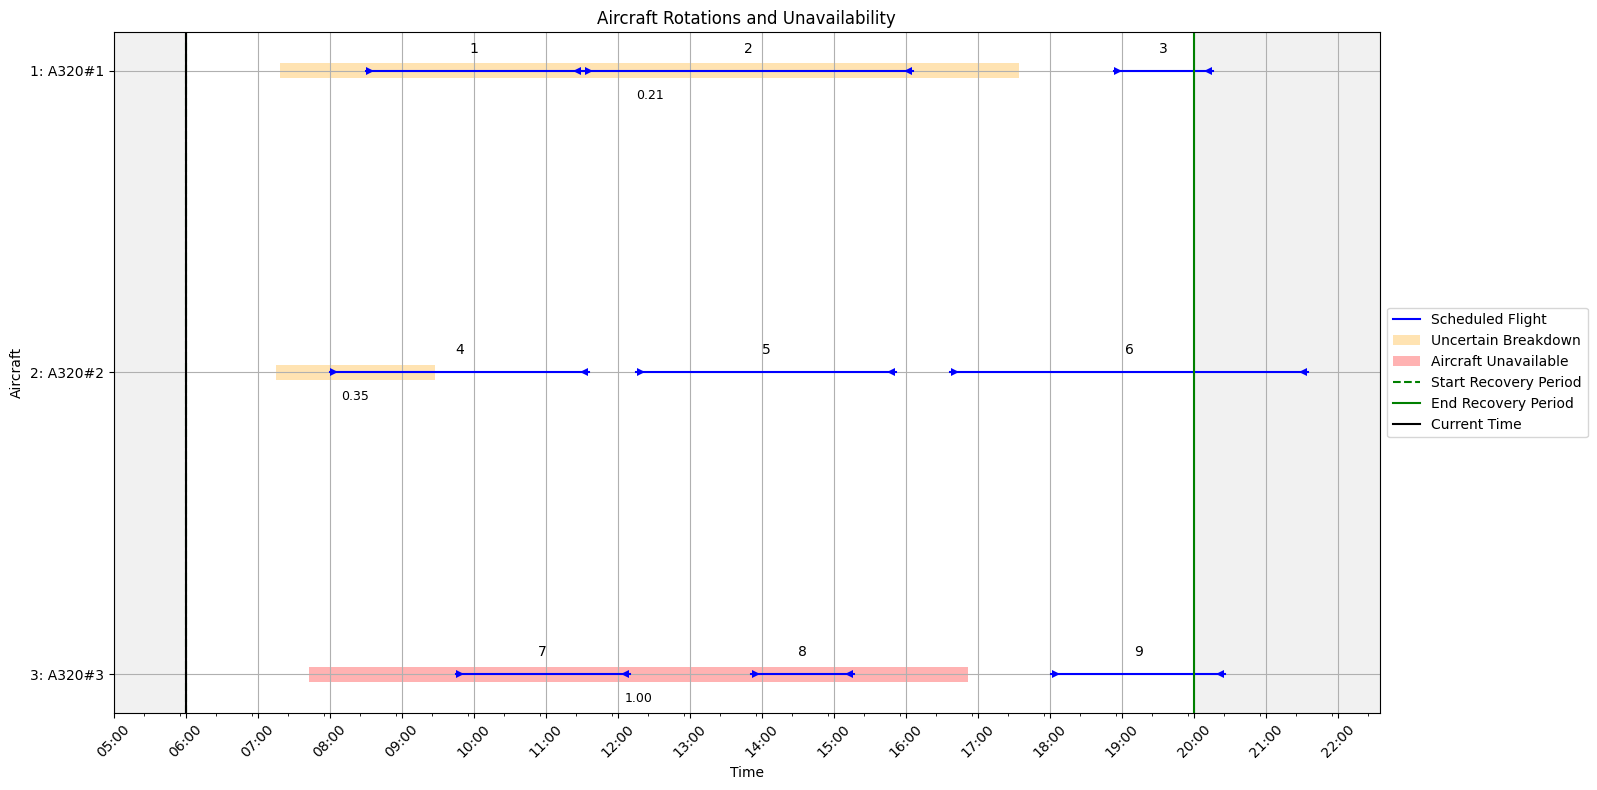

Q-values for each action:
Action (0, 0): 2980.77294921875
Action (0, 1): 3226.373779296875
Action (0, 2): 1968.7742919921875
Action (0, 3): 3954.5341796875
Action (1, 0): 1584.423828125
Action (1, 1): 3888.4111328125
Action (1, 2): 3637.52783203125
Action (1, 3): 4149.296875
Action (2, 0): 3277.8896484375
Action (2, 1): 1291.192626953125
Action (2, 2): 2626.25634765625
Action (2, 3): 1623.18359375
Action (3, 0): 3798.807861328125
Action (3, 1): 3497.51123046875
Action (3, 2): 4758.6640625
Action (3, 3): 1996.611083984375
Action (4, 0): 3494.5087890625
Action (4, 1): 3406.619384765625
Action (4, 2): 4056.648193359375
Action (4, 3): 4300.7158203125
Action (5, 0): 990.035888671875
Action (5, 1): 2421.40576171875
Action (5, 2): 2326.93994140625
Action (5, 3): 2758.750244140625
Action (6, 0): 1950.67431640625
Action (6, 1): 1438.75732421875
Action (6, 2): 3583.746337890625
Action (6, 3): 3694.86865234375
Action (7, 0): 1624.573974609375
Action (7, 1): 2070.208984375
Action (7, 2): 3769.0205

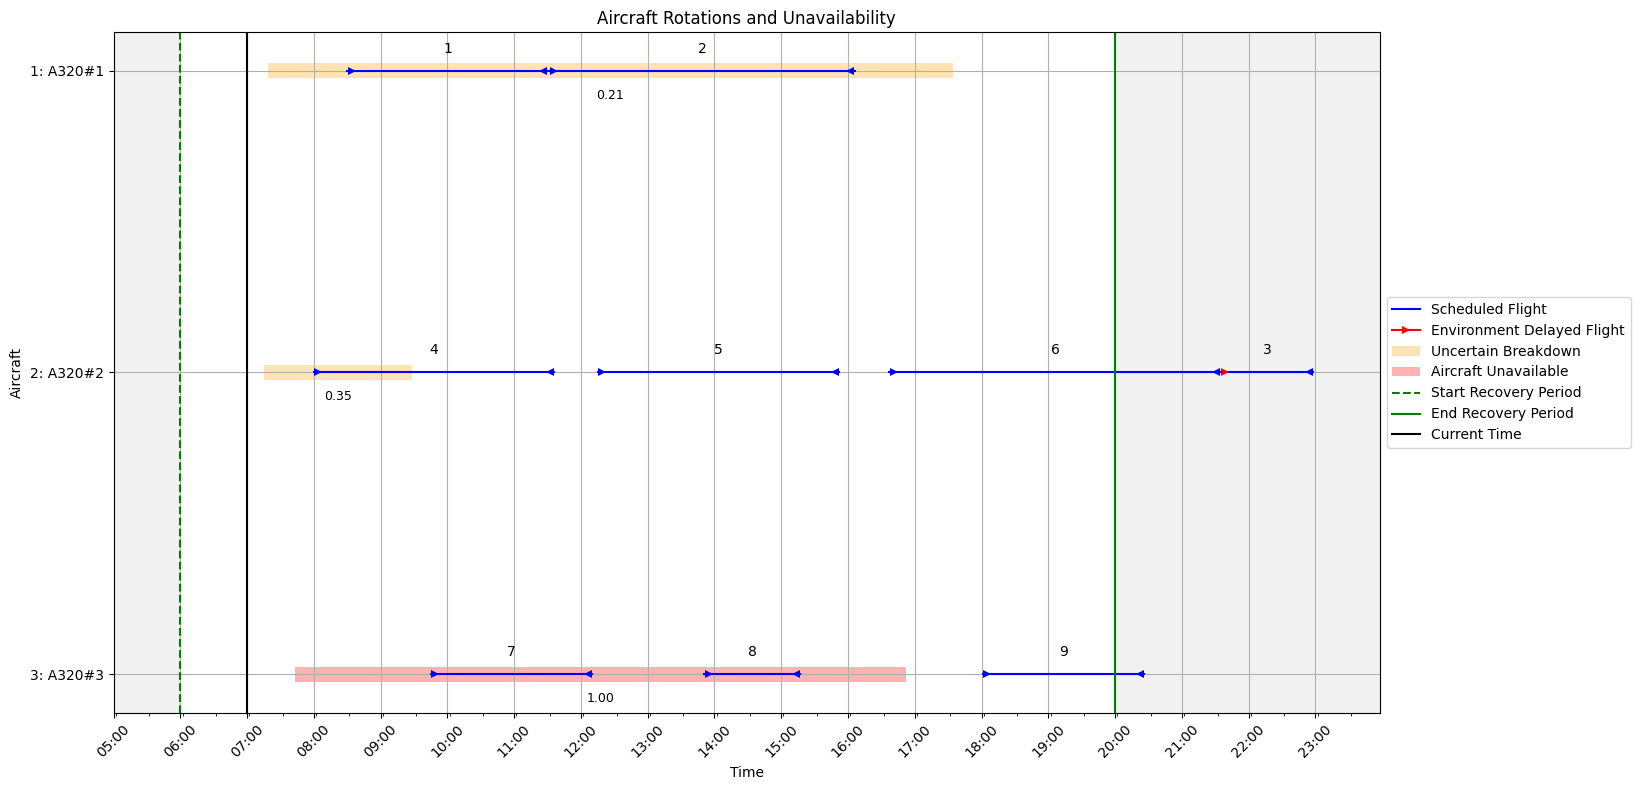

Q-values for each action:
Action (0, 0): 3371.87451171875
Action (0, 1): 3047.3935546875
Action (0, 2): 1588.388671875
Action (0, 3): 4405.775390625
Action (1, 0): 1443.093017578125
Action (1, 1): 4046.080078125
Action (1, 2): 3910.72216796875
Action (1, 3): 4165.67578125
Action (2, 0): 3190.40625
Action (2, 1): 892.4063720703125
Action (2, 2): 3082.949462890625
Action (2, 3): 1530.809326171875
Action (3, 0): 4288.11962890625
Action (3, 1): 3901.39404296875
Action (3, 2): 5189.404296875
Action (3, 3): 1891.6419677734375
Action (4, 0): 3569.027099609375
Action (4, 1): 3895.239990234375
Action (4, 2): 4229.09521484375
Action (4, 3): 4237.6953125
Action (5, 0): 248.40008544921875
Action (5, 1): 2372.326416015625
Action (5, 2): 2357.588623046875
Action (5, 3): 3320.970947265625
Action (6, 0): 1540.008544921875
Action (6, 1): 455.11297607421875
Action (6, 2): 3182.869384765625
Action (6, 3): 3296.146484375
Action (7, 0): 1427.507080078125
Action (7, 1): 1587.24951171875
Action (7, 2): 4005.

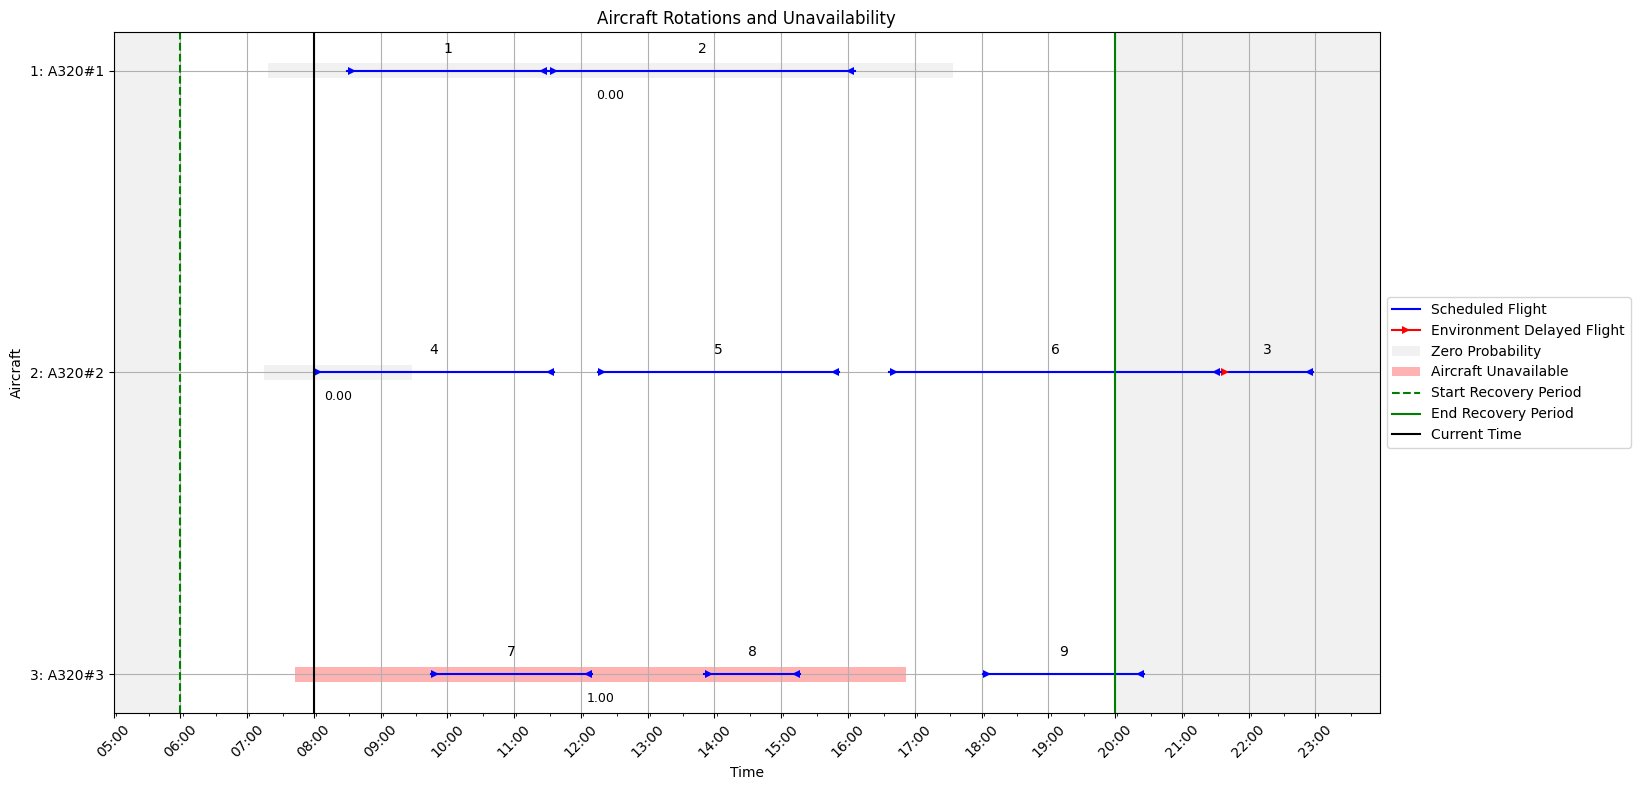

Q-values for each action:
Action (0, 0): 2191.2841796875
Action (0, 1): 1993.5869140625
Action (0, 2): 991.9844360351562
Action (0, 3): 3058.478515625
Action (1, 0): 793.4356079101562
Action (1, 1): 2678.4775390625
Action (1, 2): 2667.4248046875
Action (1, 3): 2695.97998046875
Action (2, 0): 1934.94580078125
Action (2, 1): 575.4638671875
Action (2, 2): 2359.580322265625
Action (2, 3): 874.2430419921875
Action (3, 0): 3120.515625
Action (3, 1): 2596.17041015625
Action (3, 2): 3521.742919921875
Action (3, 3): 1145.5078125
Action (4, 0): 2315.34228515625
Action (4, 1): 2355.306396484375
Action (4, 2): 3048.18994140625
Action (4, 3): 2871.435546875
Action (5, 0): 92.08120727539062
Action (5, 1): 1875.42578125
Action (5, 2): 1256.1585693359375
Action (5, 3): 2383.02685546875
Action (6, 0): 1089.8824462890625
Action (6, 1): 506.8106689453125
Action (6, 2): 1861.5521240234375
Action (6, 3): 2106.127685546875
Action (7, 0): 993.6652221679688
Action (7, 1): 1083.2889404296875
Action (7, 2): 257

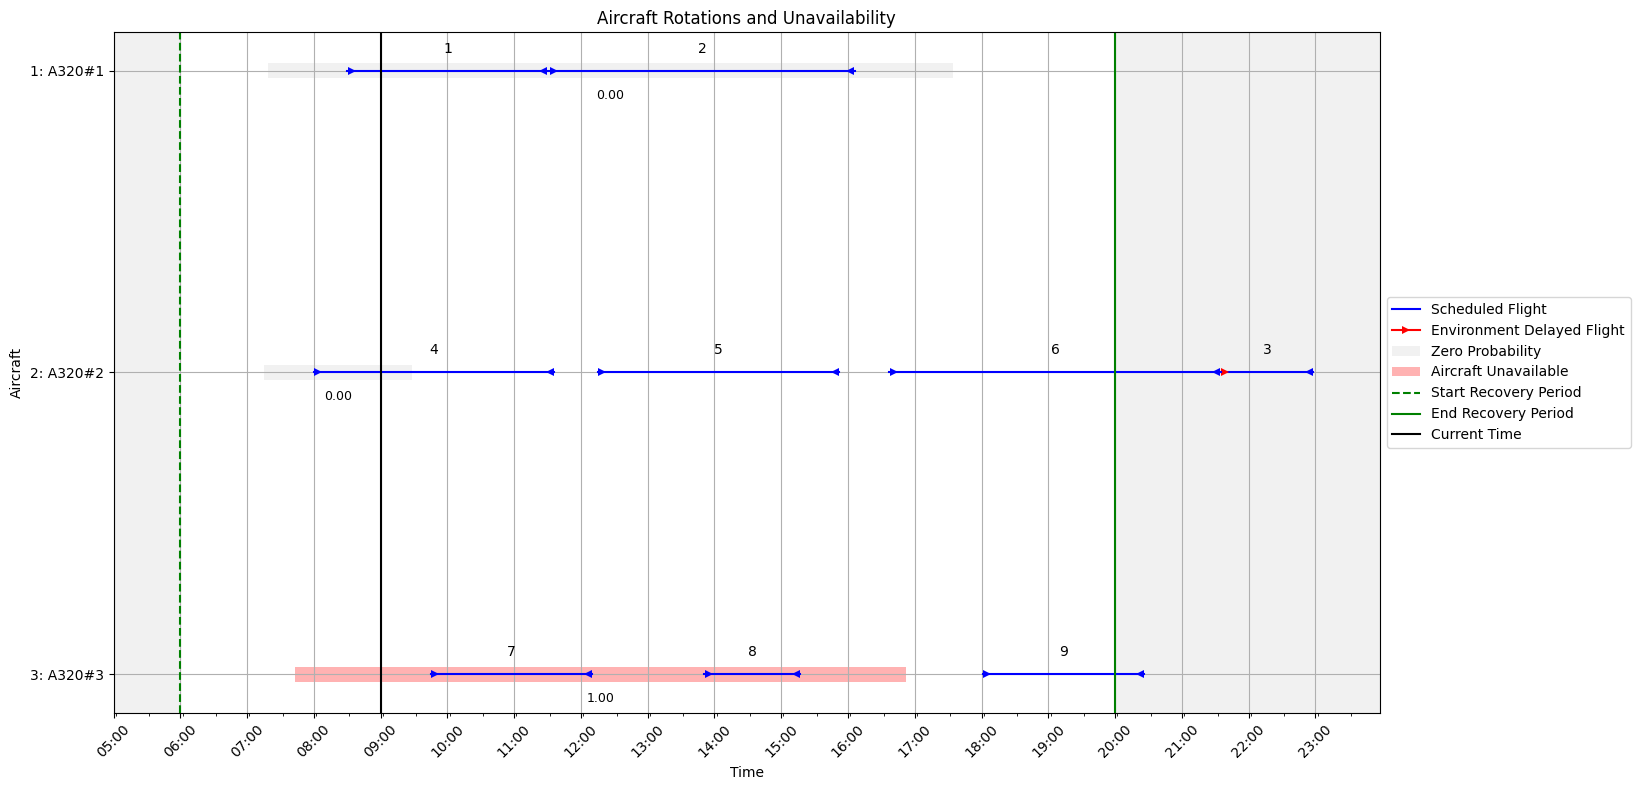

Q-values for each action:
Action (0, 0): 1059.4881591796875
Action (0, 1): 1048.17431640625
Action (0, 2): 643.1119995117188
Action (0, 3): 1592.3253173828125
Action (1, 0): -inf
Action (1, 1): -inf
Action (1, 2): -inf
Action (1, 3): -inf
Action (2, 0): 724.0853881835938
Action (2, 1): 507.61834716796875
Action (2, 2): 1566.78857421875
Action (2, 3): 343.279296875
Action (3, 0): 1730.2740478515625
Action (3, 1): 1382.643310546875
Action (3, 2): 1742.8095703125
Action (3, 3): 456.4689025878906
Action (4, 0): -inf
Action (4, 1): -inf
Action (4, 2): -inf
Action (4, 3): -inf
Action (5, 0): -17.888763427734375
Action (5, 1): 1260.7244873046875
Action (5, 2): 329.93841552734375
Action (5, 3): 1295.9356689453125
Action (6, 0): 538.3689575195312
Action (6, 1): 671.3392944335938
Action (6, 2): 523.8242797851562
Action (6, 3): 1018.7780151367188
Action (7, 0): 552.99169921875
Action (7, 1): 786.817626953125
Action (7, 2): 1289.51416015625
Action (7, 3): 2.42010498046875
Action (8, 0): 253.370300

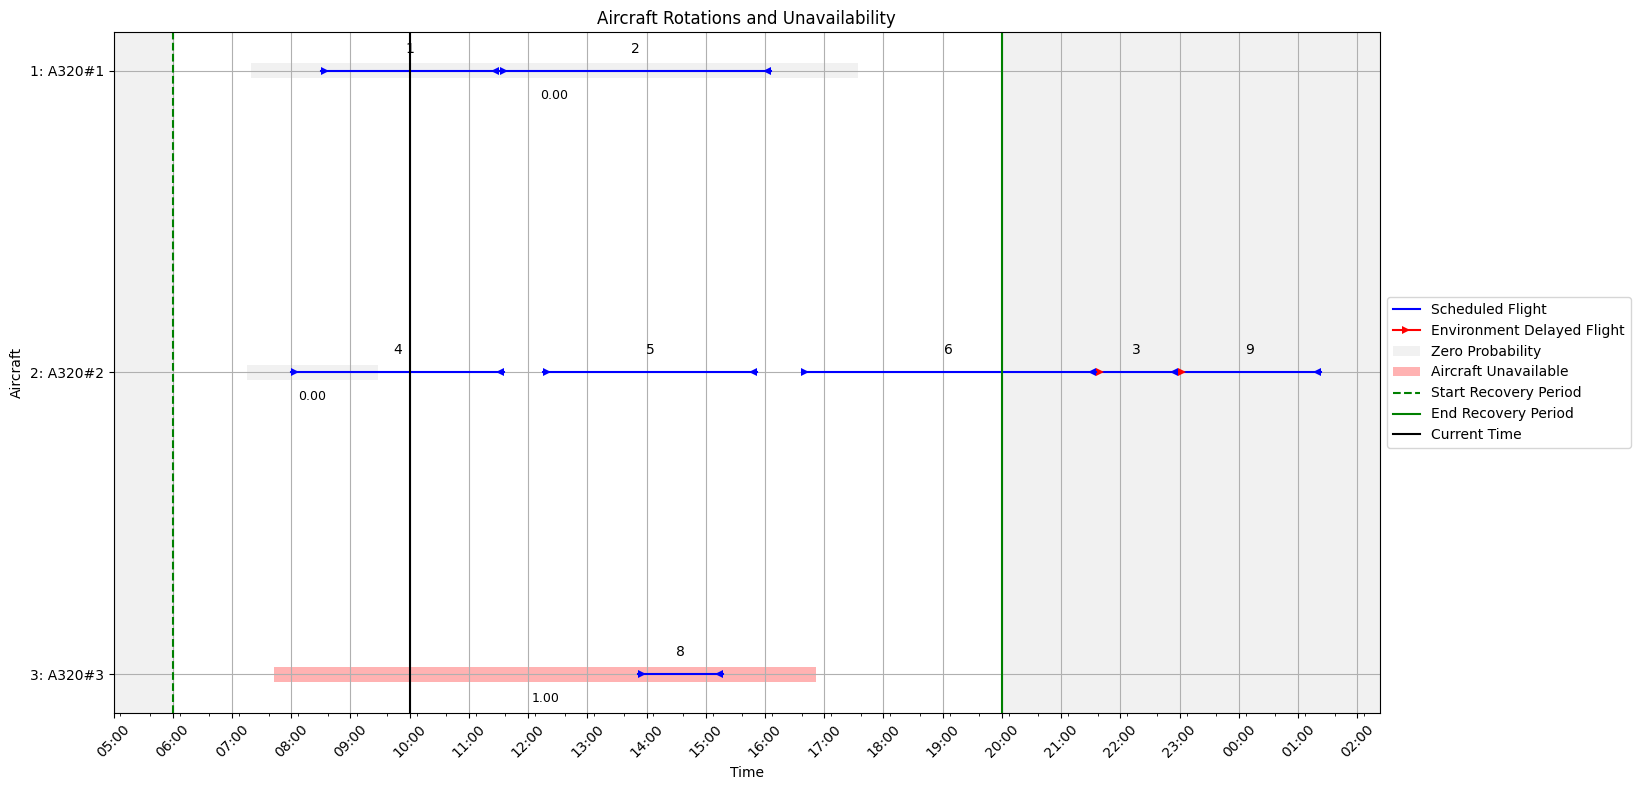

Q-values for each action:
Action (0, 0): 915.434814453125
Action (0, 1): 1069.0462646484375
Action (0, 2): 829.7989501953125
Action (0, 3): 844.1572265625
Action (1, 0): -inf
Action (1, 1): -inf
Action (1, 2): -inf
Action (1, 3): -inf
Action (2, 0): 618.0226440429688
Action (2, 1): 763.5716552734375
Action (2, 2): 809.0562133789062
Action (2, 3): 849.233642578125
Action (3, 0): 668.8154296875
Action (3, 1): 1118.359375
Action (3, 2): 1227.7525634765625
Action (3, 3): 398.1225891113281
Action (4, 0): -inf
Action (4, 1): -inf
Action (4, 2): -inf
Action (4, 3): -inf
Action (5, 0): 270.0167236328125
Action (5, 1): 1309.87353515625
Action (5, 2): 466.65447998046875
Action (5, 3): 1206.3408203125
Action (6, 0): 126.25483703613281
Action (6, 1): 504.2635803222656
Action (6, 2): 737.372802734375
Action (6, 3): 942.554443359375
Action (7, 0): -inf
Action (7, 1): -inf
Action (7, 2): -inf
Action (7, 3): -inf
Action (8, 0): 147.50686645507812
Action (8, 1): -271.8758544921875
Action (8, 2): -146.3

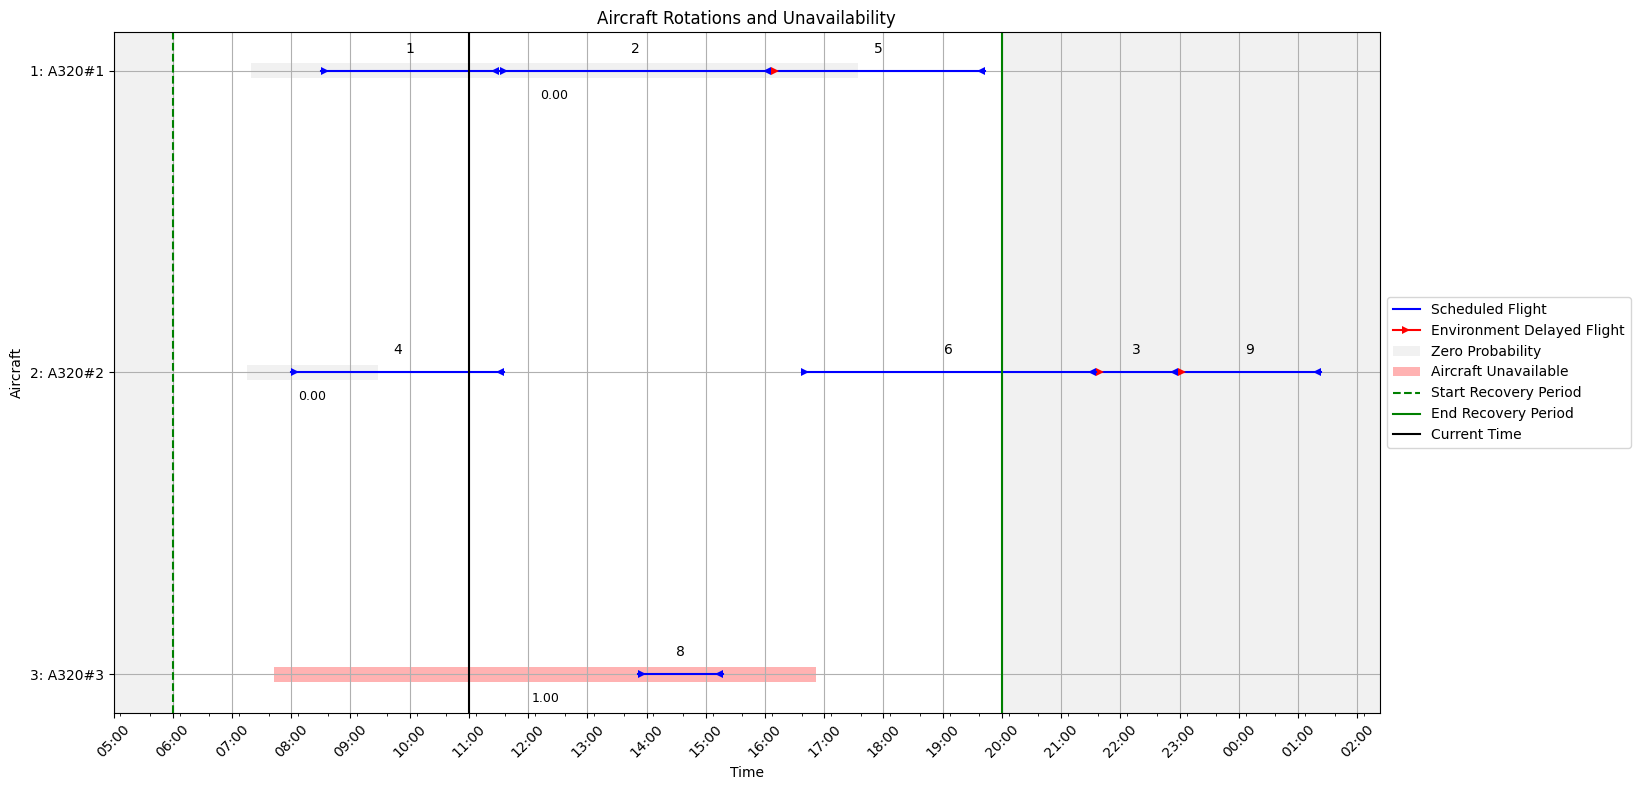

Q-values for each action:
Action (0, 0): 235.5909881591797
Action (0, 1): 176.27438354492188
Action (0, 2): 279.43048095703125
Action (0, 3): 244.12930297851562
Action (1, 0): -inf
Action (1, 1): -inf
Action (1, 2): -inf
Action (1, 3): -inf
Action (2, 0): -541.3363037109375
Action (2, 1): 7.240257263183594
Action (2, 2): -637.440185546875
Action (2, 3): 146.3133087158203
Action (3, 0): -675.8377075195312
Action (3, 1): 224.44204711914062
Action (3, 2): -330.3409118652344
Action (3, 3): -679.4529418945312
Action (4, 0): -inf
Action (4, 1): -inf
Action (4, 2): -inf
Action (4, 3): -inf
Action (5, 0): -64.25780487060547
Action (5, 1): 712.739990234375
Action (5, 2): 165.50082397460938
Action (5, 3): 627.2798461914062
Action (6, 0): -266.7821350097656
Action (6, 1): -96.77129364013672
Action (6, 2): 491.00567626953125
Action (6, 3): -207.71817016601562
Action (7, 0): -inf
Action (7, 1): -inf
Action (7, 2): -inf
Action (7, 3): -inf
Action (8, 0): 227.742431640625
Action (8, 1): -221.94778442

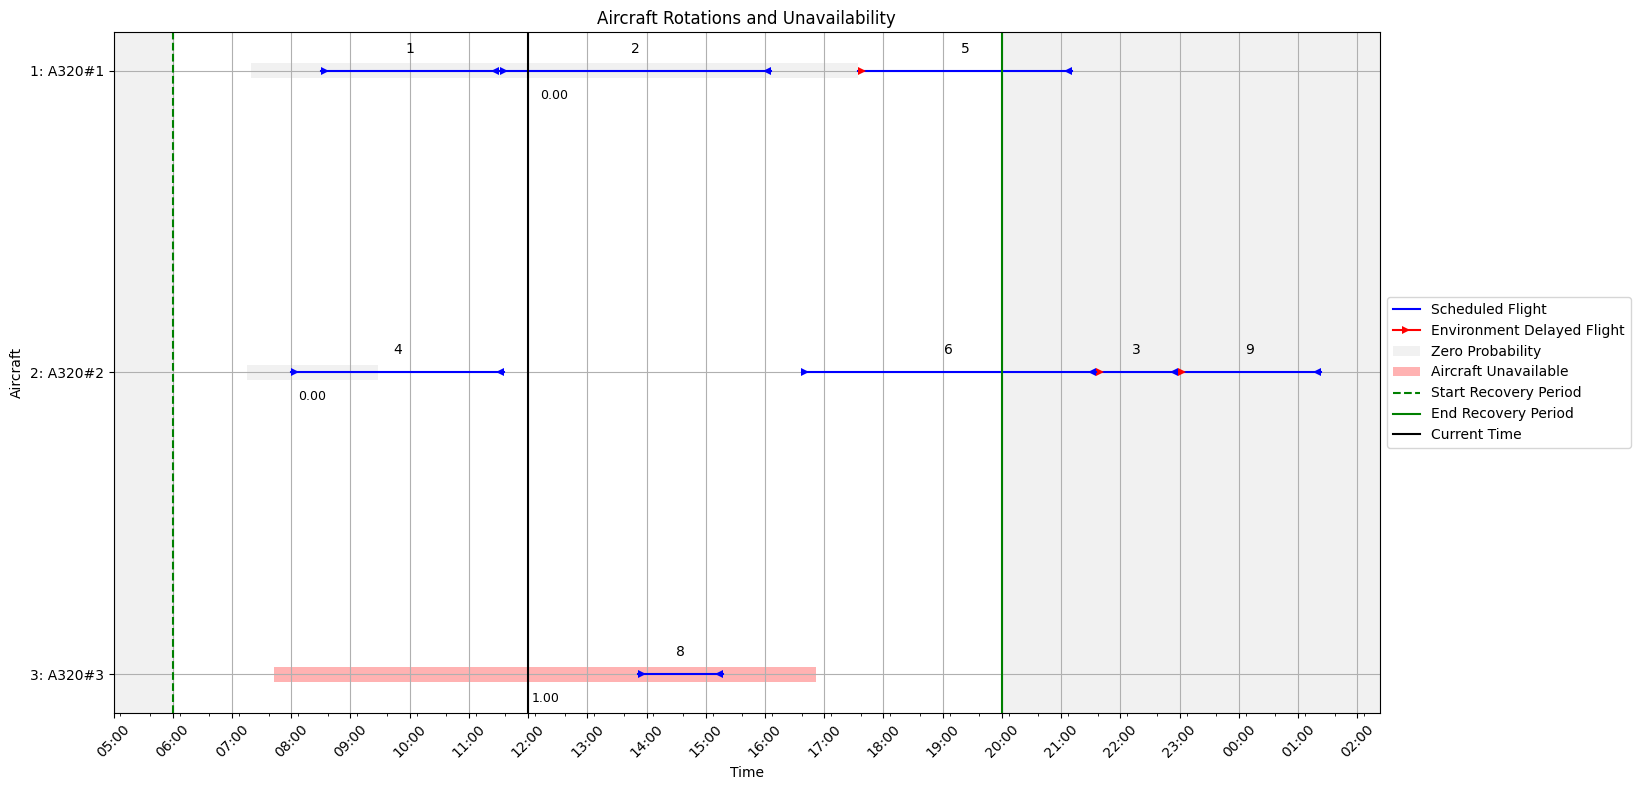

Q-values for each action:
Action (0, 0): -144.8376007080078
Action (0, 1): -212.25732421875
Action (0, 2): -88.36283874511719
Action (0, 3): -39.922576904296875
Action (1, 0): -inf
Action (1, 1): -inf
Action (1, 2): -inf
Action (1, 3): -inf
Action (2, 0): -inf
Action (2, 1): -inf
Action (2, 2): -inf
Action (2, 3): -inf
Action (3, 0): -955.3486938476562
Action (3, 1): -105.77774047851562
Action (3, 2): -851.5611572265625
Action (3, 3): -1018.6278076171875
Action (4, 0): -inf
Action (4, 1): -inf
Action (4, 2): -inf
Action (4, 3): -inf
Action (5, 0): -300.001220703125
Action (5, 1): 378.8860168457031
Action (5, 2): 162.78622436523438
Action (5, 3): 150.47789001464844
Action (6, 0): -434.3578796386719
Action (6, 1): -296.0976867675781
Action (6, 2): 337.6427001953125
Action (6, 3): -501.6320495605469
Action (7, 0): -inf
Action (7, 1): -inf
Action (7, 2): -inf
Action (7, 3): -inf
Action (8, 0): 279.091064453125
Action (8, 1): -143.78048706054688
Action (8, 2): -210.9366912841797
Action (8, 

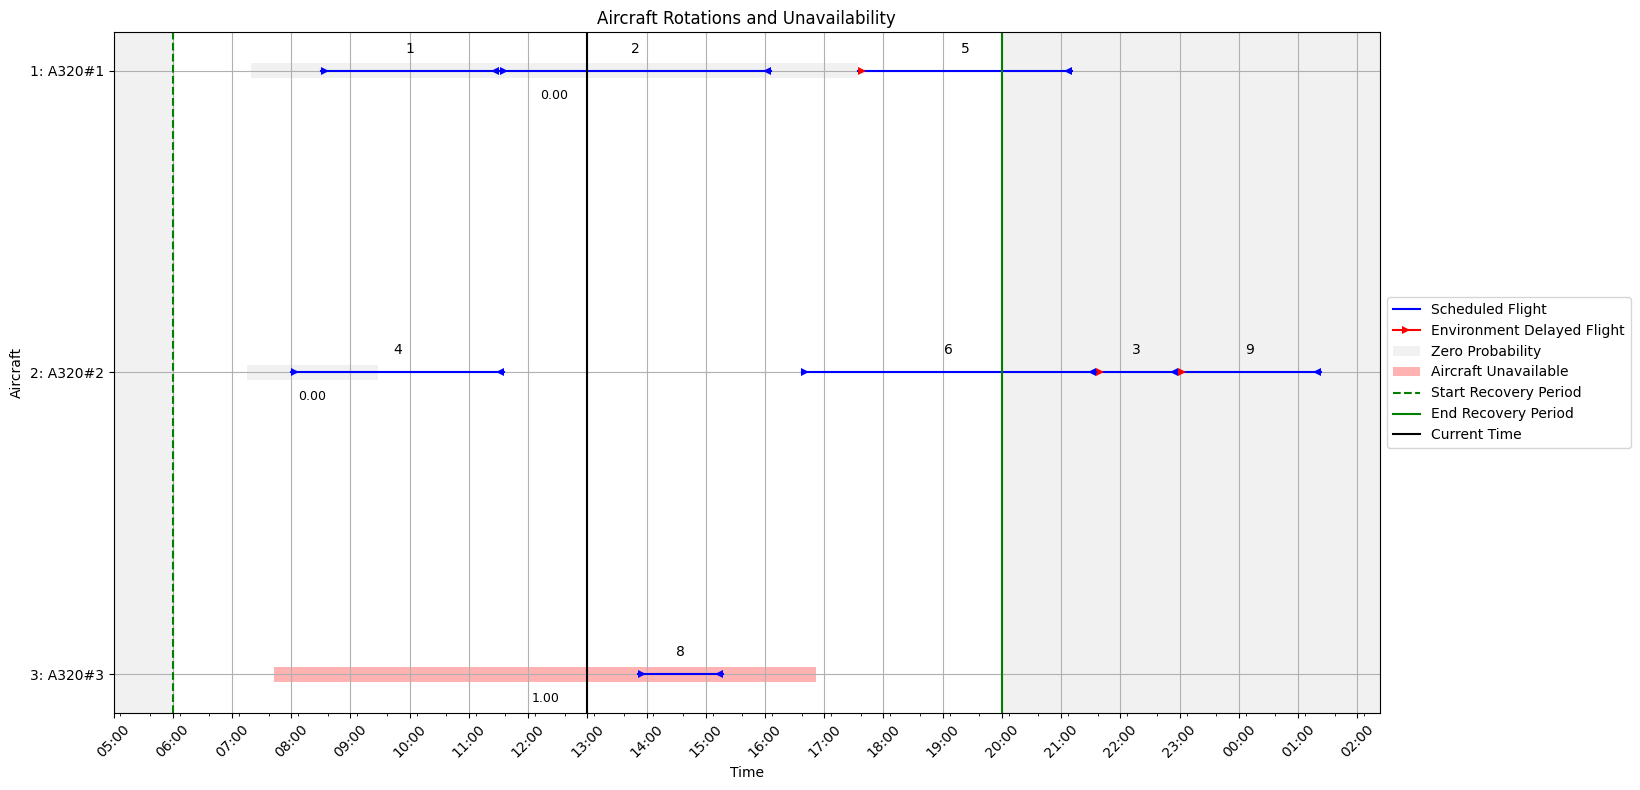

Q-values for each action:
Action (0, 0): -289.34393310546875
Action (0, 1): -338.27789306640625
Action (0, 2): -309.2023620605469
Action (0, 3): -152.03189086914062
Action (1, 0): -inf
Action (1, 1): -inf
Action (1, 2): -inf
Action (1, 3): -inf
Action (2, 0): -inf
Action (2, 1): -inf
Action (2, 2): -inf
Action (2, 3): -inf
Action (3, 0): -847.6724853515625
Action (3, 1): -254.1991729736328
Action (3, 2): -707.6575317382812
Action (3, 3): -908.115966796875
Action (4, 0): -inf
Action (4, 1): -inf
Action (4, 2): -inf
Action (4, 3): -inf
Action (5, 0): -249.1416778564453
Action (5, 1): 75.26580810546875
Action (5, 2): -245.22671508789062
Action (5, 3): -45.553466796875
Action (6, 0): -389.21630859375
Action (6, 1): -487.83447265625
Action (6, 2): 206.6741943359375
Action (6, 3): -600.0614624023438
Action (7, 0): -inf
Action (7, 1): -inf
Action (7, 2): -inf
Action (7, 3): -inf
Action (8, 0): 275.94354248046875
Action (8, 1): -11.5574951171875
Action (8, 2): -122.23069763183594
Action (8, 3)

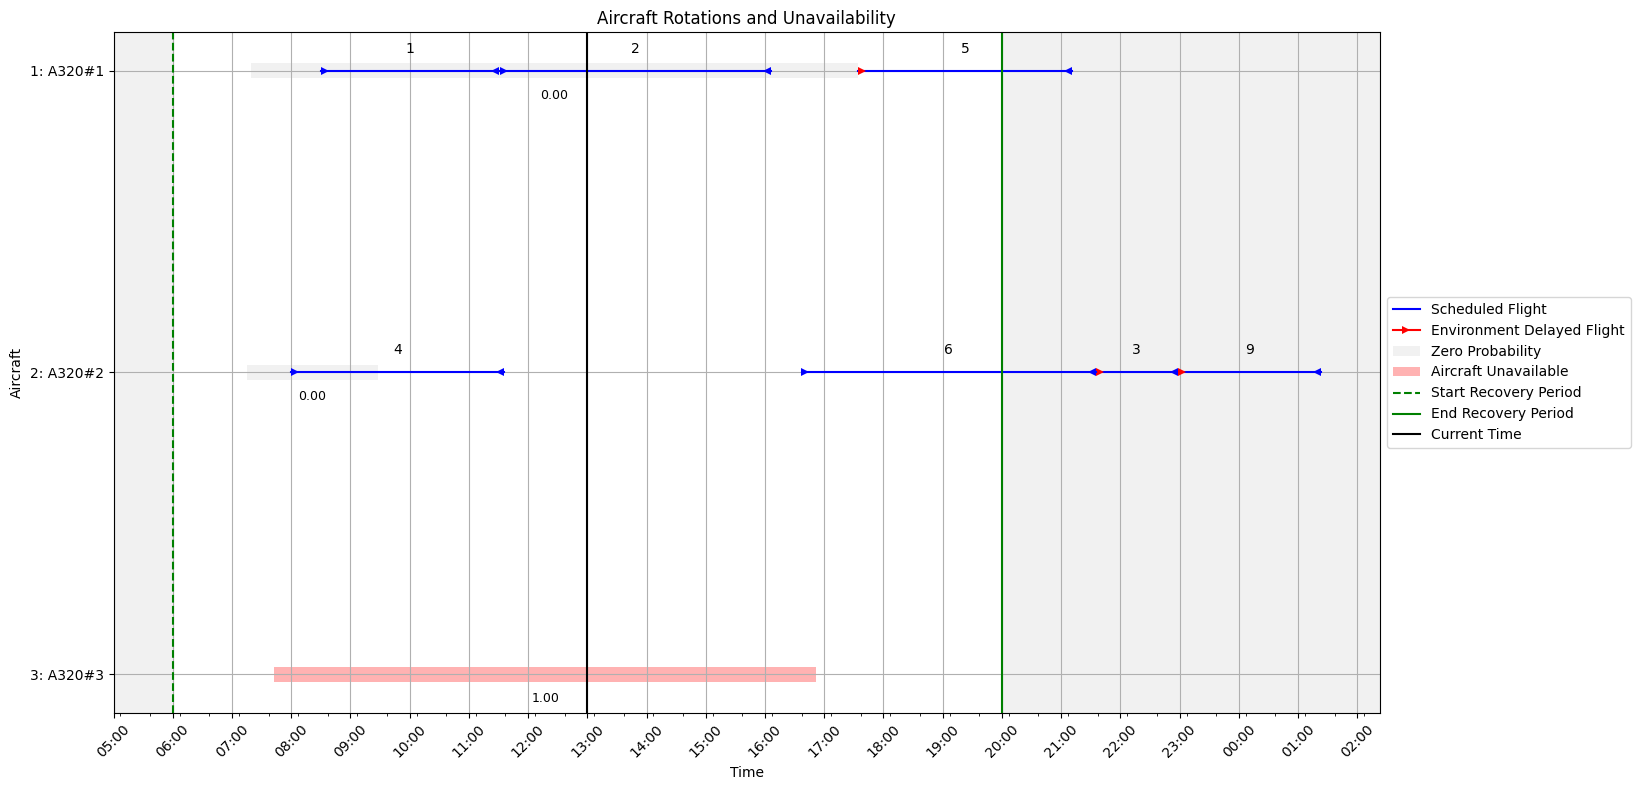

Total Reward: -4972.0
Total Steps: 8


(-4972.0, 8)

In [37]:
import os
import numpy as np
from stable_baselines3 import DQN
from src.environment import AircraftDisruptionEnv
from scripts.visualizations import StatePlotter
from scripts.utils import load_scenario_data
from src.config import *
import re
import torch

# Load the model and run inference
def run_inference_dqn(model_path, scenario_folder, env_type):
    # Load the scenario data
    data_dict = load_scenario_data(scenario_folder)

    # Extract necessary data for the environment
    aircraft_dict = data_dict['aircraft']
    flights_dict = data_dict['flights']
    rotations_dict = data_dict['rotations']
    alt_aircraft_dict = data_dict['alt_aircraft']
    config_dict = data_dict['config']

    # Initialize the environment
    env = AircraftDisruptionEnv(
        aircraft_dict, 
        flights_dict, 
        rotations_dict, 
        alt_aircraft_dict, 
        config_dict,
        env_type=env_type
    )

    # Load the trained model and set the environment
    model = DQN.load(model_path)
    model.set_env(env)

    # Set model to evaluation mode
    model.policy.set_training_mode(False)
    model.exploration_rate = 0.0

    # Set random seed for reproducibility
    np.random.seed(42)
    torch.manual_seed(42)

    # Set random seed to completely random
    np.random.seed(None)
    # torch.manual_seed(None)


    # Create StatePlotter object for visualizing the environment state
    state_plotter = StatePlotter(
        aircraft_dict=env.aircraft_dict,
        flights_dict=env.flights_dict,
        rotations_dict=env.rotations_dict,
        alt_aircraft_dict=env.alt_aircraft_dict,
        start_datetime=env.start_datetime,
        end_datetime=env.end_datetime,
        uncertain_breakdowns=env.uncertain_breakdowns,
    )

    # Reset the environment for inference
    obs, _ = env.reset()
    done_flag = False
    total_reward = 0
    step_num = 0
    max_steps = 1000  # Set a maximum number of steps to prevent infinite loops

    while not done_flag and step_num < max_steps:
        # Visualize the current state
        print(f"Step {step_num}:")

        # Extract necessary information from the environment for plotting
        swapped_flights = env.swapped_flights
        environment_delayed_flights = env.environment_delayed_flights
        current_datetime = env.current_datetime

        # Retrieve the updated dictionaries from the environment
        updated_flights_dict = env.flights_dict
        updated_rotations_dict = env.rotations_dict
        updated_alt_aircraft_dict = env.alt_aircraft_dict
        cancelled_flights = env.penalized_cancelled_flights

        if DEBUG_MODE_VISUALIZATION:
            print("Flights Dict:")
            print(updated_flights_dict)
            print("Alt Aircraft Dict:")
            print(updated_alt_aircraft_dict)
            print("Swapped Flights:")
            print(swapped_flights)
            print("Environment Delayed Flights:")
            print(environment_delayed_flights)
            print("Cancelled Flights:")
            print(cancelled_flights)
            print("Unavailabilities:")
            print(env.alt_aircraft_dict)
            print("Uncertain Breakdowns:")
            for key, value in env.uncertain_breakdowns.items():
                print(f"{key}: {value}")
            print("Current Breakdowns:")
            print(env.current_breakdowns)
            print("")

        # Update the StatePlotter's dictionaries with the updated ones
        state_plotter.alt_aircraft_dict = updated_alt_aircraft_dict
        state_plotter.flights_dict = updated_flights_dict
        state_plotter.rotations_dict = updated_rotations_dict

        # Plot the state using the updated dictionaries
        state_plotter.plot_state(
            updated_flights_dict, swapped_flights, environment_delayed_flights, cancelled_flights, current_datetime
        )

        # Get the action mask from the environment
        action_mask = obs['action_mask']

        # Convert observation to float32
        obs = {key: np.array(value, dtype=np.float32) for key, value in obs.items()}

        # Get the action mask from the observation
        action_mask = obs.get('action_mask', None)
        if action_mask is None:
            raise ValueError("Action mask is missing in the observation!")

        # Get the Q-values and apply the action mask
        obs_tensor = model.policy.obs_to_tensor(obs)[0]
        q_values = model.policy.q_net(obs_tensor).detach().cpu().numpy().squeeze()

        # Mask invalid actions by setting their Q-values to -inf
        masked_q_values = q_values.copy()
        masked_q_values[action_mask == 0] = -np.inf

        # Print the Q-values for each action
        print("Q-values for each action:")
        for i in range(len(masked_q_values)):
            print(f"Action {env.map_index_to_action(i)}: {masked_q_values[i]}")

        # Predict the action using the masked Q-values
        action = np.argmax(masked_q_values)

        # Verify if the action is valid
        if action_mask[action] == 0:
            raise ValueError(f"Invalid action selected by the model: {action}")

        # Take action in the environment
        obs, reward, terminated, truncated, info = env.step(action)

        # Accumulate the reward
        total_reward += reward

        action_mapped = env.map_index_to_action(action)
        print(f"Action taken: {action_mapped}, Reward: {reward}")

        # Combine terminated and truncated flags
        done_flag = terminated or truncated

        step_num += 1

    print("================================================")
    print("Final state:")
    # Plot final state
    state_plotter.plot_state(
        updated_flights_dict, 
        swapped_flights, 
        environment_delayed_flights, 
        cancelled_flights, 
        current_datetime
    )

    print(f"Total Reward: {total_reward}")
    print(f"Total Steps: {step_num}")

    return total_reward, step_num

# Specify the model path and the scenario folder
MODEL_PATH = "../trained_models/proactive_3ac-single-10k-1.zip"
SCENARIO_FOLDER = '../Data/Example/3ac-12f-1dis-F/Scenario_01'

# Extract the env_type using regex
match = re.search(r'/(myopic|proactive)_', MODEL_PATH)
env_type = match.group(1) if match else None

print(f"Environment Type: {env_type}")

# Verify folder and model exist
if not os.path.exists(SCENARIO_FOLDER):
    raise FileNotFoundError(f"Scenario folder not found: {SCENARIO_FOLDER}")

if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Model file not found: {MODEL_PATH}")

# Run the fixed inference loop
run_inference_dqn(MODEL_PATH, SCENARIO_FOLDER, env_type)
